# Importar pacotes

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

In [2]:
df = pd.read_pickle('clustered_embeddings.pkl')
df.head()

,index,sentence,embedding,cluster
0,0,14 DE JULHO NA ROÇA Raul Pompéia (A.G. da S.) ...,"[-0.024415258, 0.052543327, -0.024992008, 0.03...",-1
1,1,Ecoa na história com as mesmas vibrações que d...,"[0.0007392184, 0.065883435, -0.081729, 0.02044...",664
2,2,A Marselhesa é o gemido humano chamado às armas.,"[-0.001958345, 0.13307045, -0.073053285, 0.031...",647
3,3,A queda da Bastilha é o pavoroso esboroamento ...,"[0.07455372, 0.090829216, -0.095271945, -0.002...",453
4,4,A pirâmide da opressão tinha por base o grande...,"[0.010334389, -0.0013282513, -0.04966849, 0.00...",-1


# Cluster a classificar

In [3]:
unique, counts = np.unique(np.array(df['cluster']), return_counts=True)
clustersSorted = sorted(zip(unique, counts), key=lambda x: x[1])
clustersSorted.reverse()
[f'{x[0]}: {x[1]}' for x in clustersSorted[0:20]]

['-1: 191734',
 '30: 6108',
 '458: 5109',
 '283: 4276',
 '481: 3864',
 '277: 3402',
 '630: 3277',
 '419: 3234',
 '355: 3044',
 '601: 2841',
 '1: 2760',
 '422: 2708',
 '639: 2487',
 '139: 2468',
 '447: 2412',
 '272: 2394',
 '618: 2375',
 '536: 2369',
 '583: 2368',
 '171: 2352']

- Foi escolhido o Cluster 458 para classificar (relacionado a casa, casamento, esposa). <3

In [3]:
CLUSTER_CLASSIFICACAO = 458

# Split treino teste:

In [4]:
embeddingArray = df['embedding']
shape = (embeddingArray.shape[0], embeddingArray[0].shape[0])
X = np.concatenate(embeddingArray).reshape(shape)

variavelClassificacao = df['cluster'].apply(lambda x: 1 if x==CLUSTER_CLASSIFICACAO else 0)
Y = np.array(variavelClassificacao)

print(X.shape, Y.shape)

(487230, 384) (487230,)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(365422, 384) (365422,) (121808, 384) (121808,)


# Treinamento:

In [7]:
clf = make_pipeline(
  StandardScaler(),
  SGDClassifier(loss="log_loss", class_weight='balanced', max_iter=1000, tol=1e-3)
)
clf.fit(x_train, y_train)

,steps,"[('standardscaler', ...), ('sgdclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15


# Resultado:

In [8]:
def showAccuracy(y_test, y_pred):
  print("  - Accuracy:", accuracy_score(y_test, y_pred))

def showClassificationReport(y_test, y_pred):
  report_dict = classification_report(y_test, y_pred, output_dict=True)
  del report_dict['accuracy']
  report_df = pd.DataFrame(report_dict).transpose()

  # Exibir como tabela
  print("Relatório de Classificação:")
  showAccuracy(y_test, y_pred)
  display(report_df)

def showConfusionMatrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  # Normalizar por linha para classe desbalanceada
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  labels = ['Negativo', 'Positivo']

  plt.figure(figsize=(6, 5))
  sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predito")
  plt.ylabel("Real")
  plt.title("Matriz de Confusão")
  plt.show()

def showCrossValScore(x_train, y_train):
  # Essa função não altera o primeiro clf. 
  scores = cross_val_score(clf, x_train, y_train, cv=5)
  print("Cross-validation scores:", scores)
  print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [0.98570158 0.98576999 0.98623502 0.9852909  0.98650867]
Mean CV accuracy: 0.9859012329057683
Relatório de Classificação:
  - Accuracy: 0.9858465782214633


,precision,recall,f1-score,support
0,0.999521,0.986169,0.992800,120524.0
1,0.423981,0.955607,0.587362,1284.0
macro avg,0.711751,0.970888,0.790081,121808.0
weighted avg,0.993454,0.985847,0.988526,121808.0


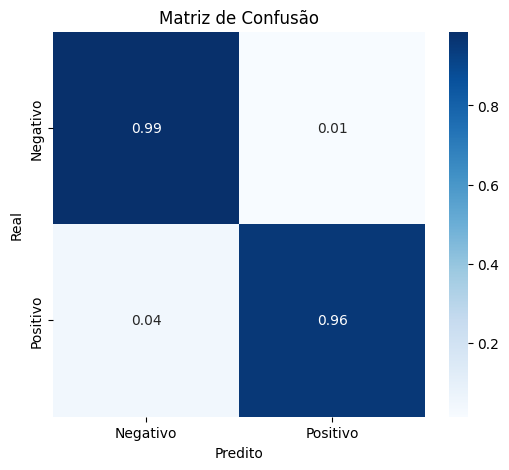

In [9]:
y_pred = clf.predict(x_test)

showCrossValScore(x_train, y_train)

showClassificationReport(y_test, y_pred)
showConfusionMatrix(y_test, y_pred)

- A base de dados é fortemente desbalanceada.
- Aplicando o SGDClassifier sem o parâmetro class_weight='balanced', o resultado tem grande presença de falsos negativos.
- Quando foi aplicado o parâmetro, o resultado ficou melhor do que utilizando threshold para classificação.
- A próxima etapa mostra essa diferença.
- Contudo, é melhor utilizar o modelo sem o threshold calculado abaixo.

# Verificar confiança do modelo (probabilidades)

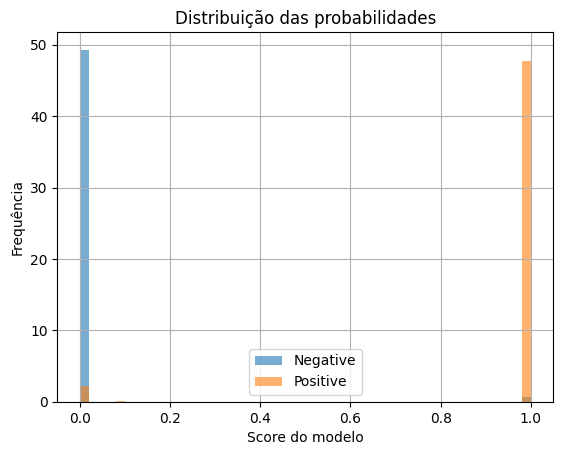

In [10]:
# Obtenha scores para cada instância (probabilidade ou decision function)
try:
  # para classificadores com probabilidade
  y_scores = clf.predict_proba(x_test)[:, 1]
except AttributeError:
  # fallback para classifiers sem probabilidade
  y_scores = clf.decision_function(x_test)

plt.hist(y_scores[y_test == 0], bins=50, alpha=0.6, label='Negative', density=True)
plt.hist(y_scores[y_test == 1], bins=50, alpha=0.6, label='Positive', density=True)
plt.title('Distribuição das probabilidades')
plt.xlabel('Score do modelo')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()

## Curva Precision X Recall

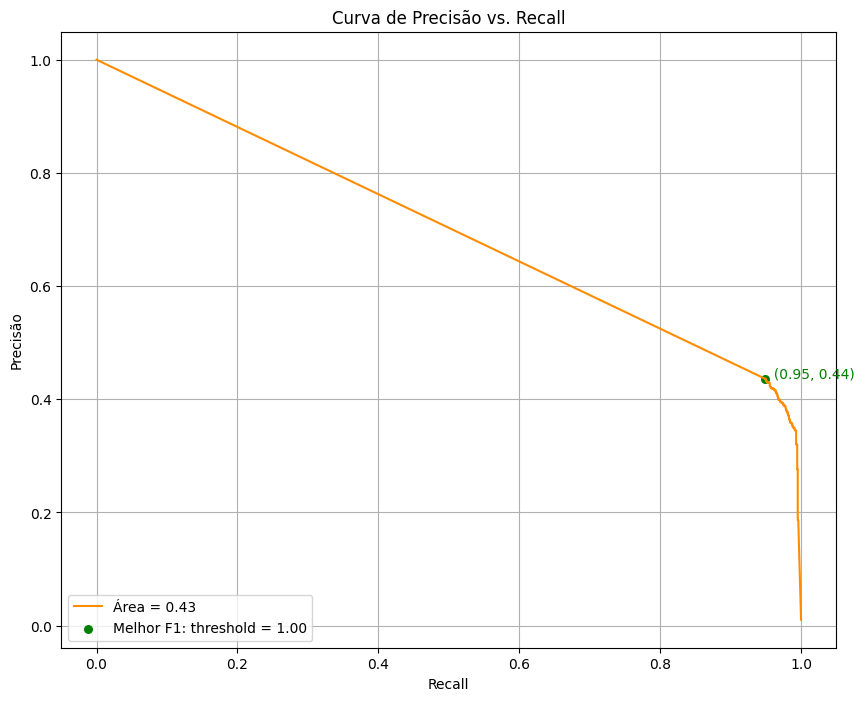

In [11]:
# Calcular precisão e recall para vários thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Achar o melhor índice (maior F1)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Pontuação média da área sob a curva
average_precision = average_precision_score(y_test, y_scores)

# Encontrar o índice do melhor F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_precision = precision[best_idx]
best_recall = recall[best_idx]

# Plotar a curva
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'Área = {average_precision:.2f}', color='darkorange')

# Destacar o melhor ponto
plt.scatter(best_recall, best_precision, color="green", s=30, label=f"Melhor F1: threshold = {best_threshold:.2f}")
plt.text(best_recall, best_precision, f'  ({best_recall:.2f}, {best_precision:.2f})', color='green')

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precisão vs. Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## Curva ROC

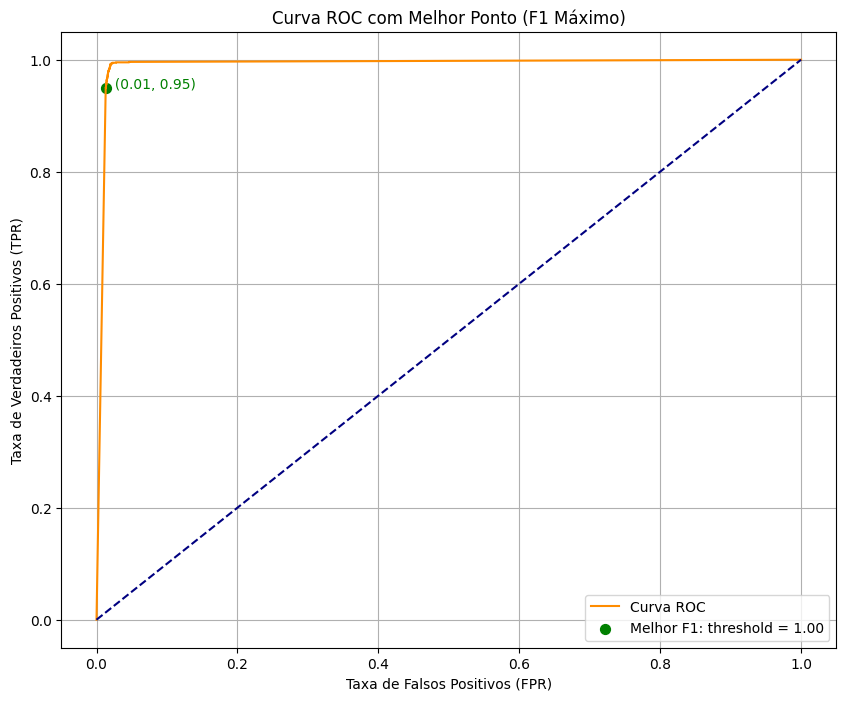

In [12]:
# ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)

# Precisão-Recall para calcular F1 em cada ponto
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)

# Achar o melhor índice (maior F1)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Agora, encontrar o ponto correspondente na curva ROC mais próximo desse threshold
# (já que os thresholds da ROC e PR não são iguais)
closest_roc_idx = np.argmin(np.abs(roc_thresholds - best_threshold))
best_fpr = fpr[closest_roc_idx]
best_tpr = tpr[closest_roc_idx]

# Plotar a curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label="Curva ROC", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")

# Destacar o melhor ponto
plt.scatter(best_fpr, best_tpr, color="green", s=50, label=f"Melhor F1: threshold = {best_threshold:.2f}")
plt.text(best_fpr, best_tpr, f"  ({best_fpr:.2f}, {best_tpr:.2f})", color='green')

# Plotar a curva
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC com Melhor Ponto (F1 Máximo)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Predict aplicando threshold:

Relatório de Classificação:
  - Accuracy: 0.9865526073821096


,precision,recall,f1-score,support
0,0.999454,0.986949,0.993162,120524.0
1,0.436605,0.949377,0.598135,1284.0
macro avg,0.718029,0.968163,0.795649,121808.0
weighted avg,0.993521,0.986553,0.988998,121808.0


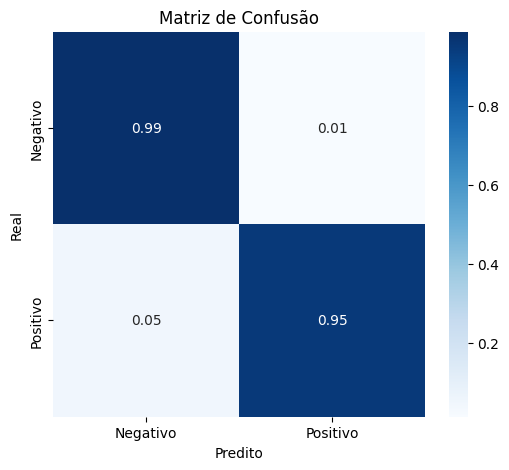

In [13]:
y_pred_custom = (y_scores >= best_threshold).astype(int)

showClassificationReport(y_test, y_pred_custom)
showConfusionMatrix(y_test, y_pred_custom)

# Classificação

## Exemplo de setenças da classe:

In [6]:
exemplosClasse = df[df['cluster'] == CLUSTER_CLASSIFICACAO].sample(n=10)
exemplosFora = df[(df['cluster'] != CLUSTER_CLASSIFICACAO) & (df['cluster'] != -1)].sample(n=10)
idxClasse = exemplosClasse.index
idxFora = exemplosFora.index

In [23]:
print(exemplosClasse['sentence'].values)

['— Mas o pai pode obrigá-la a casar comigo... — Não seja pedaço de asno, que uma rapariga naquelas condições não se casa senão por gosto próprio!'
 'Minha mãe faria, st pudesse, uma troca de promessa, dando parte dos seus anos para conservar-me consigo, fora do clero, casado e pai: é o que presumo, assim como suponho que rejeitou tal idéia, por lhe parecer uma deslealdade.'
 'Sigamos para a praça sagrada, a fim de o corpo ali queimarmos, e com os tições as casas incendiemos de todos os traidores.'
 'D. Carmo guiava o serviço doméstico, ajudando o pessoal deste e dando aos arranjos da casa o conforto que não poderia vir por dinheiro.'
 'Estava suspirando pela noite para sair de sua casa, e ir ter com o seu bom amigo Lotário, congratulando-se com ele de ter achado na mulher a margarida preciosa.'
 'Todos eles cantavam em coro, mais afinados que nas outras duas casas; quase, porém, que se lhes não podia ouvir as vozes, tantas e tão estrondosas eram as pragas que soltavam ao mesmo tempo.'

## Exemplo de classificação:

In [24]:
y_pred_Classe = clf.predict(X[idxClasse])
y_pred_Fora = clf.predict(X[idxFora])

sentencasResultado = list(exemplosClasse['sentence'].values) + list(exemplosFora['sentence'].values)
y_pred_resultado = y_pred_Classe.tolist() + y_pred_Fora.tolist()
y_resultado = Y[idxClasse].tolist() + Y[idxFora].tolist()

dfResultado = pd.DataFrame({
  "sentencas": sentencasResultado,
  "classe_pred": y_pred_resultado,
  "classe": y_resultado
})

In [26]:
def tipo_erro(row):
  if row['classe'] == 1 and row['classe_pred'] == 0:
    return 'Falso Negativo'
  elif row['classe'] == 0 and row['classe_pred'] == 1:
    return 'Falso Positivo'
  elif row['classe'] == 1:
    return 'Verdadeiro Positivo'
  else:
    return 'Verdadeiro Negativo'

dfResultado['acerto'] = dfResultado['classe_pred'] == dfResultado['classe']
dfResultado['tipo'] = dfResultado.apply(tipo_erro, axis=1)

print(dfResultado['sentencas'].values)
dfResultado

['— Mas o pai pode obrigá-la a casar comigo... — Não seja pedaço de asno, que uma rapariga naquelas condições não se casa senão por gosto próprio!'
 'Minha mãe faria, st pudesse, uma troca de promessa, dando parte dos seus anos para conservar-me consigo, fora do clero, casado e pai: é o que presumo, assim como suponho que rejeitou tal idéia, por lhe parecer uma deslealdade.'
 'Sigamos para a praça sagrada, a fim de o corpo ali queimarmos, e com os tições as casas incendiemos de todos os traidores.'
 'D. Carmo guiava o serviço doméstico, ajudando o pessoal deste e dando aos arranjos da casa o conforto que não poderia vir por dinheiro.'
 'Estava suspirando pela noite para sair de sua casa, e ir ter com o seu bom amigo Lotário, congratulando-se com ele de ter achado na mulher a margarida preciosa.'
 'Todos eles cantavam em coro, mais afinados que nas outras duas casas; quase, porém, que se lhes não podia ouvir as vozes, tantas e tão estrondosas eram as pragas que soltavam ao mesmo tempo.'

,sentencas,classe_pred,classe,acerto,tipo
0,— Mas o pai pode obrigá-la a casar comigo... —...,1,1,True,Verdadeiro Positivo
1,"Minha mãe faria, st pudesse, uma troca de prom...",1,1,True,Verdadeiro Positivo
2,"Sigamos para a praça sagrada, a fim de o corpo...",1,1,True,Verdadeiro Positivo
3,"D. Carmo guiava o serviço doméstico, ajudando ...",1,1,True,Verdadeiro Positivo
4,Estava suspirando pela noite para sair de sua ...,1,1,True,Verdadeiro Positivo
5,"Todos eles cantavam em coro, mais afinados que...",1,1,True,Verdadeiro Positivo
6,Eu penso que o casamento deve ser um namoro et...,1,1,True,Verdadeiro Positivo
7,Carlos dobrou a Rua dos Ourives e dirigiu-se à...,1,1,True,Verdadeiro Positivo
8,Outro casamento efetuou-se por esse tempo!,1,1,True,Verdadeiro Positivo
9,"Para a tarde, porém, com o roxo e melancólico ...",1,1,True,Verdadeiro Positivo


### Embeddings selecionadas para teste

In [ ]:
sentencasResultado = list(exemplosClasse['sentence'].values) + list(exemplosFora['sentence'].values)
y_resultado = Y[idxClasse].tolist() + Y[idxFora].tolist()
embedding = list(exemplosClasse['embedding'].values) + list(exemplosFora['embedding'].values)
data = str([x.tolist() for x in embedding])
print(data)
print(embedding[0].shape)

[[0.029560992494225502, 0.05825606733560562, 0.015624815598130226, -0.006409191060811281, -0.10238683968782425, -0.019101101905107498, -0.037050146609544754, -0.0336930938065052, -0.01490815356373787, 0.0589379221200943, 0.07482940703630447, -0.04892433434724808, 0.036381565034389496, -0.03364308923482895, -0.010748741216957569, -0.017982741817831993, -0.04215433821082115, 0.022857969626784325, 0.05650858208537102, 0.07523617893457413, 0.11991025507450104, -0.021479899063706398, -0.03471742942929268, 0.05117848142981529, -0.03948235511779785, 0.045006975531578064, 0.019001848995685577, 0.0219185221940279, -0.01295563206076622, -0.007099148817360401, 0.04791227728128433, 0.06931573152542114, 0.13778391480445862, -0.0601922832429409, 0.03757762908935547, -0.016321273520588875, 0.05573366582393646, -0.030951276421546936, -0.011550619266927242, -0.0008589110220782459, -0.017903484404087067, -0.0214911587536335, 0.052162282168865204, -0.027069782838225365, 0.011345881968736649, -0.062247708

### Reduzir tamanho do dataframe para o cliente mlflow (somente para subir um exemplo no git, já que o arquivo gerado é muito grande)

In [61]:
n_samples = df[df['cluster'] == CLUSTER_CLASSIFICACAO].shape[0]

dfSlim = df.copy()
dfSlim['cluster'] = dfSlim['cluster'].apply(lambda x: x if x==CLUSTER_CLASSIFICACAO else -1)

balanced_df = dfSlim.groupby('cluster').sample(n=n_samples, random_state=42)
print(balanced_df['cluster'].value_counts())
balanced_df = balanced_df.reset_index(drop=True)
balanced_df.to_pickle("clustered_embeddings_slim.pkl")

cluster
-1      5109
 458    5109
Name: count, dtype: int64
